<h1> Node Classification using Graph Convolutional Networks </h1>

This project was undertaken by our team consisting of:

Seedella Sai Vikas (420233)
Vedagiri Krishna Sandeep (420247)
Matta Rahul (420206)

This node classification task uses CORA dataset <br>
The dataset consists of <b>2708</b> nodes which correspond to scientific publications.<br>
The nodes are classified into <b>7</b> categories indicating the topics of each document.<br>
The edges indicate whether a document is cited by the other or vice versa.<br>
Each node has <b>1433</b> features which is described by a 0/1-valued vector, indicating the bag-of-words from the dictionary.<br>

<br> This is an undirected graph problem

In [1]:
#importing dependencies

import numpy as np
import os
import networkx as nx
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GraphConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

<h2> Data Loading and Preprocessing </h2><br>
We are going to use the edges connecting the  (from file <b>cora.cites</b>).<br>
The nodes are loaded from file <b>cora.content</b>.

In [2]:
#loading the data

all_data = []
all_edges = []

for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

                
#Shuffle the data because the raw data is ordered based on the label
random_state = 77
all_data = shuffle(all_data,random_state=random_state)

In <b>cora.content</b> file:<br>
The <b>first</b> element indicates the <b>node name</b><br>
The <b>second</b> until the last second elements indicate the <b>node features</b><br>
The <b>last</b> element indicates the <b>label of that particular node</b><br>

In <b>cora.cites</b> file:<br>
Each line indicates the tuple of connected nodes


<h3>Parsing the data</h3>

In [3]:
#parse the data
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0] #the number of nodes
F = X.shape[1] #the size of node features
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Genetic_Algorithms', 'Probabilistic_Methods', 'Theory', 'Rule_Learning', 'Case_Based', 'Reinforcement_Learning', 'Neural_Networks'}

Number of classes:  7


<h3> Select examples for training, validation, and test then set the mask</h3>

In [4]:
def limit_data(labels,limit=20,val_num=500,test_num=1000):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1
        
        #exit the loop once we found 20 examples for each class
        if all(count == limit for count in label_counter.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    #get the first val_num
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx


train_idx,val_idx,test_idx = limit_data(labels)

In [5]:
#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

<h3>Show Data Distribution</h3>

In [6]:
print("All Data Distribution: \n{}".format(Counter(labels)))

All Data Distribution: 
Counter({'Neural_Networks': 818, 'Probabilistic_Methods': 426, 'Genetic_Algorithms': 418, 'Theory': 351, 'Case_Based': 298, 'Reinforcement_Learning': 217, 'Rule_Learning': 180})


In [7]:
print("Training Data Distribution: \n{}".format(Counter([labels[i] for i in train_idx])))

Training Data Distribution: 
Counter({'Reinforcement_Learning': 20, 'Probabilistic_Methods': 20, 'Neural_Networks': 20, 'Case_Based': 20, 'Theory': 20, 'Genetic_Algorithms': 20, 'Rule_Learning': 20})


In [8]:
print("Validation Data Distribution: \n{}".format(Counter([labels[i] for i in val_idx])))

Validation Data Distribution: 
Counter({'Neural_Networks': 172, 'Genetic_Algorithms': 78, 'Probabilistic_Methods': 72, 'Theory': 63, 'Case_Based': 58, 'Reinforcement_Learning': 35, 'Rule_Learning': 22})


<h3>Convert the labels to one hot encoding</h3>

In [9]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)

<h3>Build a graph on NetworkX using the obtained nodes and edges list</h3>

In [10]:
#build the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

#obtain the adjacency matrix (A)
A = nx.adjacency_matrix(G)
print('Graph info: ', nx.info(G))

Graph info:  Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


<h2> Building and Training Graph Convolutional Networks </h2>

In [11]:
# Parameters
channels = 16           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 10        # Patience for early stopping

# Preprocessing operations
A = GraphConv.preprocess(A).astype('f4')

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GraphConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GraphConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1433)]       0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1433)         0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2708)]       0                                            
__________________________________________________________________________________________________
graph_conv (GraphConv)          (None, 16)           22928       dropout[0][0]                    
                                                                 input_2[0][0]                

In [31]:
# Train model
validation_data = ([X, A], labels_encoded, val_mask)
model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])

Epoch 1/200
1/1 [==============================] - 0s 421ms/step - loss: 0.1165 - acc: 0.2000 - val_loss: 0.3639 - val_acc: 0.3480
Epoch 2/200
1/1 [==============================] - 0s 220ms/step - loss: 0.1093 - acc: 0.3429 - val_loss: 0.3525 - val_acc: 0.5140
Epoch 3/200
1/1 [==============================] - 0s 227ms/step - loss: 0.1028 - acc: 0.5857 - val_loss: 0.3403 - val_acc: 0.5700
Epoch 4/200
1/1 [==============================] - 0s 214ms/step - loss: 0.0965 - acc: 0.6857 - val_loss: 0.3271 - val_acc: 0.6160
Epoch 5/200
1/1 [==============================] - 0s 233ms/step - loss: 0.0902 - acc: 0.7286 - val_loss: 0.3141 - val_acc: 0.6500
Epoch 6/200
1/1 [==============================] - 0s 214ms/step - loss: 0.0858 - acc: 0.7500 - val_loss: 0.3028 - val_acc: 0.6640
Epoch 7/200
1/1 [==============================] - 0s 219ms/step - loss: 0.0822 - acc: 0.7786 - val_loss: 0.2925 - val_acc: 0.6800
Epoch 8/200
1/1 [==============================] - 0s 218ms/step - loss: 0.0773 - a

Epoch 62/200
1/1 [==============================] - 0s 228ms/step - loss: 0.0366 - acc: 0.9500 - val_loss: 0.1597 - val_acc: 0.7900
Epoch 63/200
1/1 [==============================] - 0s 213ms/step - loss: 0.0367 - acc: 0.9357 - val_loss: 0.1588 - val_acc: 0.7900
Epoch 64/200
1/1 [==============================] - 0s 247ms/step - loss: 0.0378 - acc: 0.9286 - val_loss: 0.1568 - val_acc: 0.7940
Epoch 65/200
1/1 [==============================] - 0s 214ms/step - loss: 0.0355 - acc: 0.9429 - val_loss: 0.1554 - val_acc: 0.7940
Epoch 66/200
1/1 [==============================] - 0s 230ms/step - loss: 0.0327 - acc: 0.9786 - val_loss: 0.1539 - val_acc: 0.7940
Epoch 67/200
1/1 [==============================] - 0s 222ms/step - loss: 0.0343 - acc: 0.9857 - val_loss: 0.1531 - val_acc: 0.8020
Epoch 68/200
1/1 [==============================] - 0s 230ms/step - loss: 0.0347 - acc: 0.9857 - val_loss: 0.1528 - val_acc: 0.8020
Epoch 69/200
1/1 [==============================] - 0s 227ms/step - loss: 0.

In [12]:
# Evaluate model
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]


y_pred = model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.11      0.09      0.10       114
    Genetic_Algorithms       0.11      0.01      0.02       156
       Neural_Networks       0.29      0.22      0.25       290
 Probabilistic_Methods       0.39      0.14      0.21       172
Reinforcement_Learning       0.08      0.20      0.11        85
         Rule_Learning       0.08      0.52      0.14        60
                Theory       0.00      0.00      0.00       123

              accuracy                           0.15      1000
             macro avg       0.15      0.17      0.12      1000
          weighted avg       0.19      0.15      0.14      1000



<h3> Get hidden layer representation for GCN </h3>

In [13]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
#get the hidden layer representation after the first GCN layer
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

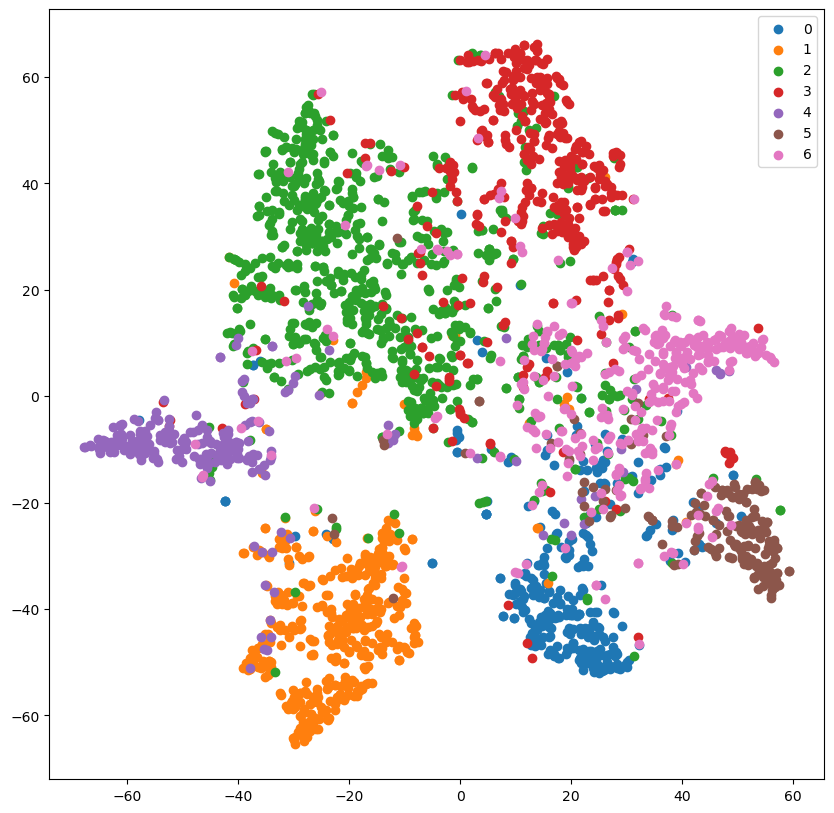

In [34]:
def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)

<h2> Comparison to Fully-Connected Neural Networks </h2>

<h3>Building and Training FNN</h3>

In [14]:
es_patience = 10
optimizer = Adam(lr=1e-2)
l2_reg = 5e-4
epochs = 200

#Compare with FNN
#Construct the model
model_fnn = Sequential()
model_fnn.add(Dense(
                    128,
                    input_dim=X.shape[1],
                    activation=tf.nn.relu,
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
             )
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(256, activation=tf.nn.relu))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(num_classes, activation=tf.keras.activations.softmax))


model_fnn.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])


#define TensorBoard
tbCallBack_FNN = TensorBoard(
    log_dir='./Tensorboard_FNN_cora',
)

#Train model
validation_data_fnn = (X, labels_encoded, val_mask)
model_fnn.fit(
                X,labels_encoded,
                sample_weight=train_mask,
                epochs=epochs,
                batch_size=N,
                validation_data=validation_data_fnn,
                shuffle=False,
                callbacks=[
                  EarlyStopping(patience=es_patience,  restore_best_weights=True),
                  tbCallBack_FNN
          ])

Epoch 1/200
1/1 [==============================] - 0s 454ms/step - loss: 0.2200 - acc: 0.1000 - val_loss: 0.4335 - val_acc: 0.2940
Epoch 2/200
1/1 [==============================] - 0s 238ms/step - loss: 0.1751 - acc: 0.3071 - val_loss: 0.3972 - val_acc: 0.4380
Epoch 3/200
1/1 [==============================] - 0s 253ms/step - loss: 0.1423 - acc: 0.5357 - val_loss: 0.3655 - val_acc: 0.5320
Epoch 4/200
1/1 [==============================] - 0s 254ms/step - loss: 0.1121 - acc: 0.7643 - val_loss: 0.3343 - val_acc: 0.5680
Epoch 5/200
1/1 [==============================] - 0s 219ms/step - loss: 0.0893 - acc: 0.7571 - val_loss: 0.3022 - val_acc: 0.5860
Epoch 6/200
1/1 [==============================] - 0s 242ms/step - loss: 0.0699 - acc: 0.8571 - val_loss: 0.2743 - val_acc: 0.6160
Epoch 7/200
1/1 [==============================] - 0s 256ms/step - loss: 0.0541 - acc: 0.9214 - val_loss: 0.2620 - val_acc: 0.6000
Epoch 8/200
1/1 [==============================] - 0s 260ms/step - loss: 0.0477 - a

In [36]:
# Evaluate model
y_pred = model_fnn.predict(X_te)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('FCNN Classification Report: \n {}'.format(report))

FCNN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.62      0.57      0.59       114
    Genetic_Algorithms       0.70      0.80      0.75       156
       Neural_Networks       0.74      0.55      0.63       290
 Probabilistic_Methods       0.63      0.60      0.62       172
Reinforcement_Learning       0.55      0.54      0.54        85
         Rule_Learning       0.35      0.65      0.46        60
                Theory       0.45      0.52      0.48       123

              accuracy                           0.60      1000
             macro avg       0.58      0.61      0.58      1000
          weighted avg       0.63      0.60      0.61      1000



<h3>Get hidden layer representation for FNN</h3>

In [15]:
layer_outputs = [layer.output for layer in model_fnn.layers] 
activation_model = Model(inputs=model_fnn.input, outputs=layer_outputs)
activations = activation_model.predict([X])

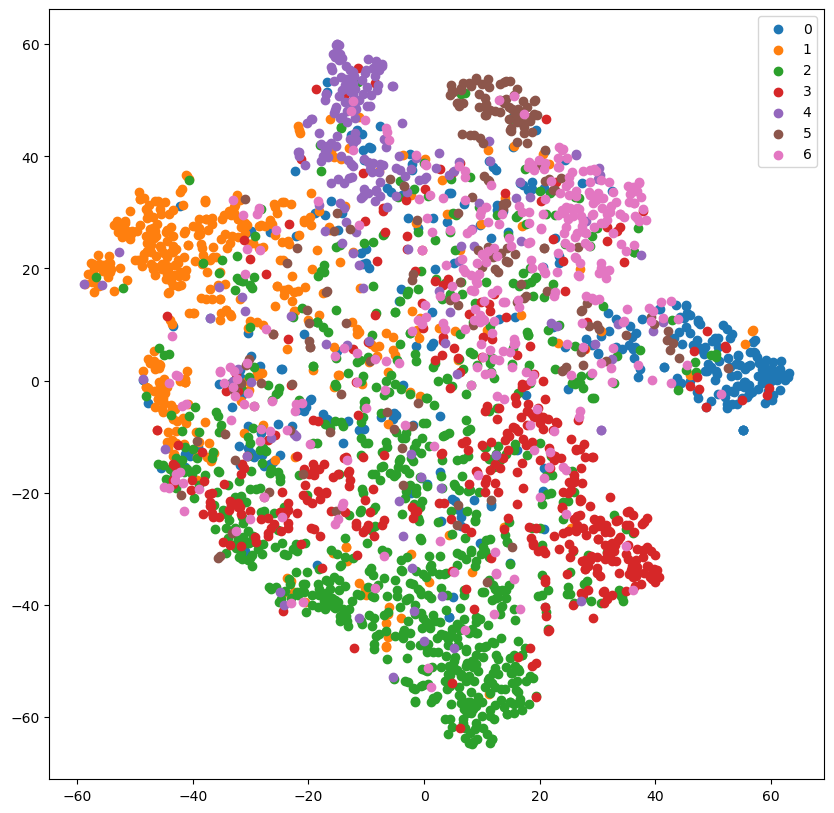

In [38]:
x_tsne = TSNE(n_components=2).fit_transform(activations[3])
plot_tSNE(labels_encoded,x_tsne)

In [39]:
### END OF NOTEBOOK ###